# Part 1 - The network of retweets

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import os
import glob
import community
import re
import nltk

from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
import string
import operator
from wordcloud import WordCloud

## Exercise 1

**Exercise 1: Build the network of retweets. We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets.**

In [2]:
#Read data file
df = pd.read_csv('./tweet_names.csv', encoding ='utf-8')

In [3]:
#Create graph
G = nx.DiGraph()

path = './tweets_2019/*'
#Construct graph by going through the twitter files
for filename in glob.glob(path):
    m = filename[14:]
    #Extract twitter name from data file
    tweet_name = df.loc[df['WikiPageName']==m]['tw_name'].item()
    #Extract party from data file
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()
    #Add node to graph
    G.add_node(tweet_name, party=party_name)
    
    #Find all retweets in twitter file
    f = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()
    retweets = re.findall(r'RT @\w*', f)
    for r in set(retweets):
        count = retweets.count(r)
        #Extract twitter name (excluding @RT)
        r = r[4:]
        #Only include edge if the retweet is from a member and if it is not a self loop
        if r in df['tw_name'].values:
            if r!=tweet_name:
                G.add_node(r, party=df.loc[df['tw_name']==r]['Party'].item())
                G.add_edge(tweet_name, r, weight=count)
            

## Exercise 2
**Visualize the network of retweets and investigate differences between the parties.**

**Visualize the network using the Networkx draw function, and nodes coordinates from the force atlas algorithm. Hint: use an undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements. Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the node-size to be proportional to total degree.**

In [4]:
#Crete undirected version for plotting
u_G = G.to_undirected()
#Extract the giant component
Gc = max(nx.connected_component_subgraphs(u_G), key=len)

forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  
                          linLogMode=False, 
                          adjustSizes=False,  
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False, 

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)


In [5]:
#Split nodes into democratics and republicans
dem_nodes = [n for (n,party) in nx.get_node_attributes(Gc,'party').items() if party == 'Democratic']
rep_nodes = [n for (n,party) in nx.get_node_attributes(Gc,'party').items() if party == 'Republican']
#Create list of degrees
d = dict(Gc.degree)
dem_degrees = [(d[node]) * 5 for node in dem_nodes]
rep_degrees = [(d[node]) * 5 for node in rep_nodes]

#Create positions
positions = forceatlas2.forceatlas2_networkx_layout(Gc, pos=None, iterations=5000)

100%|██████████| 5000/5000 [00:10<00:00, 479.50it/s]

BarnesHut Approximation  took  3.01  seconds
Repulsion forces  took  6.14  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.41  seconds


/Users/lukaavbreht/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


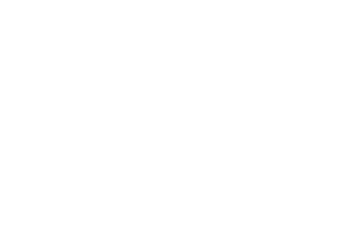

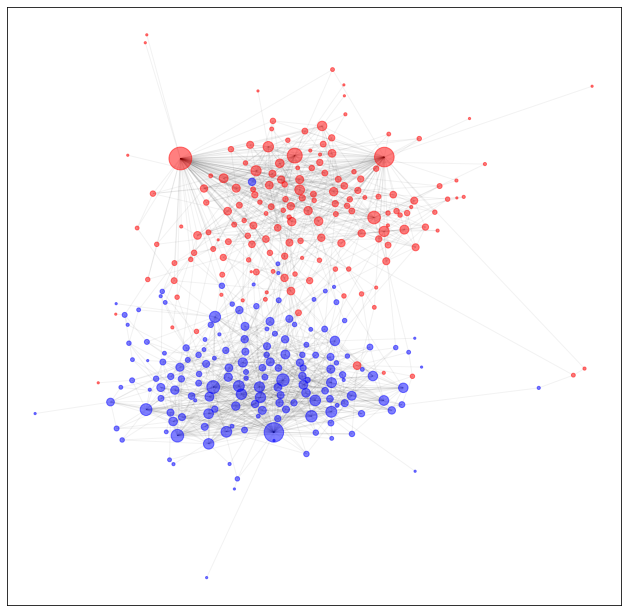

In [6]:
#Plot network where node size is proportional to degrees
plt.axis('off')
plt.figure(figsize=(11,11)) 
nx.draw_networkx_nodes(Gc, positions, nodelist=dem_nodes,node_color='blue', node_size= dem_degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_nodes(Gc, positions, nodelist=rep_nodes,node_color='red', node_size= rep_degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(Gc, positions, alpha=0.05)

plt.show()

**Compare the network of Retweets with the network of Wikipedia pages (generated during Week 5). Do you observe any differences? How do you explain them?**

Network of wikipedia pages shown below. 

<img src="network_part_5.png" alt="wiki_network" style="width:550px;"/>

It can be seen that the new network of retweets looks much more structured than that of the wikipedia pages as the parties are more separeted. This shows that politicians are much more likely to retweet content from within their own party than of the other party (which is no surprise). In the wikipedia network the edges are built from the links and one page might very well link to pages of the other party for a number of reasons.

**Now set the node-size tob proportional to betweenness centrality. Do you observe any changes?**

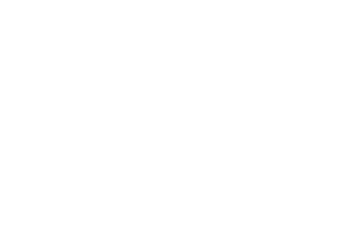

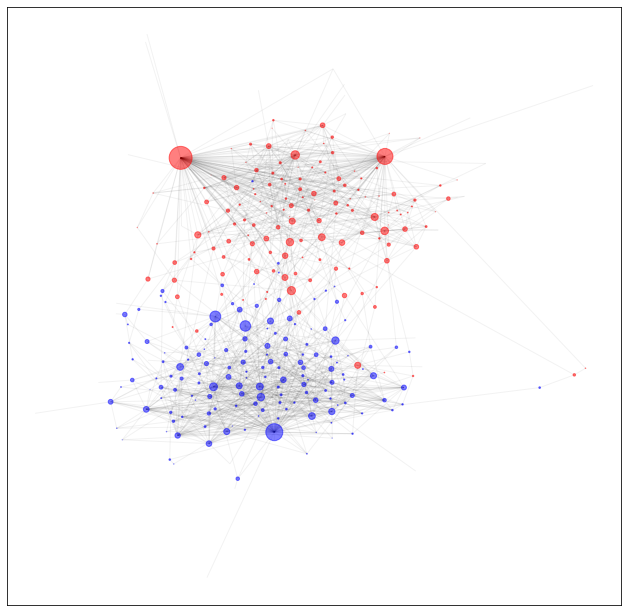

In [7]:
#Calculate the betweeness crentrality
betweeness_centrality = nx.betweenness_centrality(Gc)
dem_betweeness_centrality = [(betweeness_centrality[node]) * 2000 for node in dem_nodes]
rep_betweeness_centrality = [(betweeness_centrality[node]) * 2000 for node in rep_nodes]

#Plot network where node size is proportional to crentrality betweeness
plt.axis('off')
plt.figure(figsize=(11,11)) 
nx.draw_networkx_nodes(Gc, positions, nodelist=dem_nodes,node_color='blue', node_size= dem_betweeness_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_nodes(Gc, positions, nodelist=rep_nodes,node_color='red', node_size= rep_betweeness_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(Gc, positions, alpha=0.05)
plt.show()

Betweeness centrality indicates how many shortest paths go through a node. When setting the node size proportional to the betweeness centrality it can be observes that the same nodes are dominating the network, but there is a larger gap between the size of the larger nodes and the smaller nodes. 

**Repeat the point above using eigenvector centrality. Again, do you see a difference? Can you explain why based on what eigenvector centrality measures?**

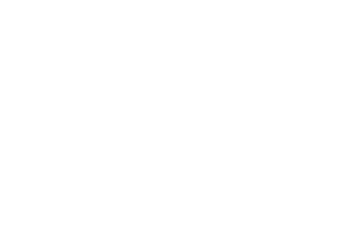

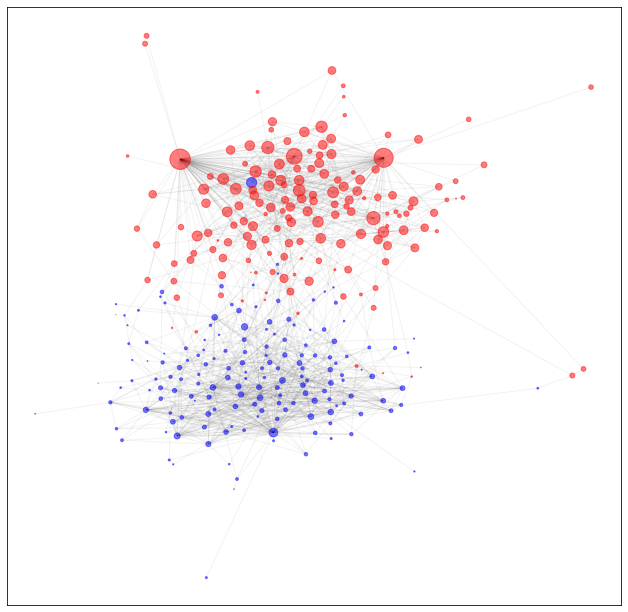

In [8]:
#Calculate eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(Gc,max_iter=500)
dem_eigenvector_centrality = [(eigenvector_centrality[node]) * 1000 for node in dem_nodes]
rep_eigenvector_centrality = [(eigenvector_centrality[node]) * 1000 for node in rep_nodes]

#Plot network where node size is proportional to eigenvector centrality
plt.axis('off')
plt.figure(figsize=(11,11)) 
nx.draw_networkx_nodes(Gc, positions, nodelist=dem_nodes,node_color='blue', node_size= dem_eigenvector_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_nodes(Gc, positions, nodelist=rep_nodes,node_color='red', node_size= rep_eigenvector_centrality, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(Gc, positions, alpha=0.05)
plt.show()

Here it can be observed that the democratic nodes are generally larger than the republic nodes. The eigenvector centrality measures the centrality of a node based on the centrality of its neighbours. If a node is connected to many nodes that have a high eigenvector centrality then that node will have high eigenvector centrality. This is an indicator of the influence a node has on the network. 

Looking at the network of betweeness centrality it can be seen that there are multiple larger nodes that are connected among the democratic nodes while this is not as clear with the republic nodes. Because of this there are more nodes in among the democratics with a high eigenvector centrality and more the republic nodes have a lower eigenvector centrality.

**Who are the three nodes with highest degree within each party? And wbat is their eigenvector centrality? And their betweenness centrality?**

In [9]:
import pprint as pp

def getDegree(n):
    return d[n];

#Sort nodes based on degree
dem_nodes.sort(key=getDegree, reverse=True)
rep_nodes.sort(key=getDegree, reverse=True)

#Print nodes with highest degree
# print('Democratic nodes with highest degree:', dem_nodes[0:3])
# print('Their betweeness centrality:\n', [x + ': '+ str(betweeness_centrality[x]) for x in dem_nodes[0:3]])
# print('Their eigenvector centrality:\n', [x + ': '+ str(eigenvector_centrality[x]) for x in dem_nodes[0:3]])
# print('\nRepublic nodes with highest degree:', rep_nodes[0:3])
# print('Their betweeness centrality:\n', [x + ': '+ str(betweeness_centrality[x]) for x in rep_nodes[0:3]])
# print('Their eigenvector centrality:\n', [x + ': '+ str(eigenvector_centrality[x]) for x in rep_nodes[0:3]])

print('Democratic nodes with highest degree:')
pp.pprint(dem_nodes[0:3])
print()

pp.pprint('Their betweeness centrality:')
pp.pprint([x + ': '+ str(betweeness_centrality[x]) for x in dem_nodes[0:3]])
print()

print('Their eigenvector centrality:')
pp.pprint([x + ': '+ str(eigenvector_centrality[x]) for x in dem_nodes[0:3]])
print("\n \n")

print('Republic nodes with highest degree:')
pp.pprint(rep_nodes[0:3])
print()

print('Their betweeness centrality:')
pp.pprint([x + ': '+ str(betweeness_centrality[x]) for x in rep_nodes[0:3]])
print()

print('Their eigenvector centrality:')
pp.pprint([x + ': '+ str(eigenvector_centrality[x]) for x in rep_nodes[0:3]])
print()

Democratic nodes with highest degree:
['SpeakerPelosi', 'RepLindaSanchez', 'RepRaulGrijalva']

'Their betweeness centrality:'
['SpeakerPelosi: 0.14524953393910742',
 'RepLindaSanchez: 0.031288659414405146',
 'RepRaulGrijalva: 0.014704717521401204']

Their eigenvector centrality:
['SpeakerPelosi: 0.0737011214682027',
 'RepLindaSanchez: 0.031249456367512148',
 'RepRaulGrijalva: 0.035898814748117416']

 

Republic nodes with highest degree:
['GOPLeader', 'SteveScalise', 'RepAndyBiggsAZ']

Their betweeness centrality:
['GOPLeader: 0.2636434059926712',
 'SteveScalise: 0.128856174781772',
 'RepAndyBiggsAZ: 0.035782991684398635']

Their eigenvector centrality:
['GOPLeader: 0.4195496153568054',
 'SteveScalise: 0.3647893073915279',
 'RepAndyBiggsAZ: 0.2500263634813289']



**Plot (on the same figure) the distribution of outgoing strength for the republican and democratic nodes repectively (i.e. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?**

In [10]:
total_retweets = {'Republican': 0, 'Democratic': 0}
#for each file count retweets (this could be done in the same loop that was used to build the network, but was 
#done here to make it easier to see what part of the assignment this belongs to)
for filename in glob.glob(path):
    m = filename[14:]
    tweet_name = df.loc[df['WikiPageName']==m]['tw_name'].item()
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()
    
    f = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()
    retweets = re.findall(r'RT @\w*', f)
    for r in set(retweets):
        r = r[4:]
        #Increment counter if the tweet comes from a member but not a the member himself
        if r in df['tw_name'].values:
            if r!=tweet_name:
                total_retweets[party_name] +=1
    

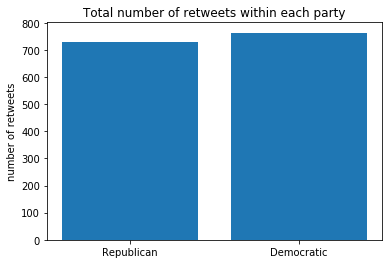

In [11]:
#Plot the number of retweets as a barplot
plt.bar(range(len(total_retweets)), list(total_retweets.values()), align='center')
plt.title("Total number of retweets within each party")
plt.ylabel("number of retweets")
plt.xticks(range(len(total_retweets)), list(total_retweets.keys()))
plt.show()

It can be seen on the plot that the democratic retweet more than the republic party.

**Find the 3 members of the republican party that have retweeted tweets from democratic members most often. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?**

In [12]:
retweets_from_other_party = {'Republican': {}, 'Democratic': {}}
#for each file count retweets from the other party (as in the previous question, 
#this could have combined with the other loops)
for filename in glob.glob(path):
    m = filename[14:]
    tweet_name = df.loc[df['WikiPageName']==m]['tw_name'].item()
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()
    retweets_from_other_party[party_name][tweet_name] = 0
    
    f = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()
    retweets = re.findall(r'RT @\w*', f)
    for r in set(retweets):
        r = r[4:]
        if r in df['tw_name'].values:
            other_party = df.loc[df['tw_name']==r]['Party'].item()
            #Only count retweet if the party of the two members is different
            if party_name != other_party:
                retweets_from_other_party[party_name][tweet_name] +=1
                
#Sort members based on number of retweets from the other party and print the highest
rep_list = sorted(retweets_from_other_party['Republican'], key=retweets_from_other_party['Republican'].get, reverse=True)
rep_name_list = [df.loc[df['tw_name']==x]['WikiPageName'].item() for x in rep_list]
print('Republicans that retweeted democratics most:', rep_name_list[0:3])
dem_list = sorted(retweets_from_other_party['Democratic'], key=retweets_from_other_party['Democratic'].get, reverse=True)
dem_name_list = [df.loc[df['tw_name']==x]['WikiPageName'].item() for x in dem_list]
print('Democratics that retweeted republicans most:', dem_name_list[0:3])

Republicans that retweeted democratics most: ['Brian_Fitzpatrick_(American_politician)', 'Jim_Sensenbrenner', 'Tom_Reed_(politician)']
Democratics that retweeted republicans most: ['Gene_Green', 'Ted_Deutch', 'Cedric_Richmond']




The politicians in Republican party that retweet tho most are:

Brian Fitzpatrick
* was ranked the third most bipartisan member of the House of Representatives.

Jim Sensenbrenner
* in office since 1979. Serving in his 21st term in the house.
* most senior member of the Wisconsin delegation
* Chairman in many Committee's

Tom Reed
* First House Republican in the new Congress to support a House rules change. (A democratic proposal)
* First to break ranks for a full rules proposal

They are all arround the same age. With simmilar political views. But just by looking at their wikipedia pages it is hard to find any significant similarities.

The politicians in Democratic party that retweet tho most are:

Ted Deutch
* Spoke out in favor of expanded gun control legislation
* Promise to Seniors Act, which aims to keep Social Security benefits
* Strong public apperances

Gene Green
* Serving for 13 terms
* Green was the only non-Hispanic white Democrat representing a significant portion of Houston
* Voted in favor of the Iraq Resolution in 2002,

Cedric Richmond
* The only Democratic Representative from Louisiana serving in the House.
* Poor/rocky childhood
* Many committee assignments

Again connections are kinda vague, Maybe the fact thall all of them have strong opinios on popullar topics is the best explanation on why they retweet the most.

## Exercise 3: Community detection
**Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network (Week 7)? Comment on your result.**

In [13]:
#Find the communities
partition = community.best_partition(Gc)
print('Modularity:', community.modularity(partition, Gc))


Modularity: 0.4846841903950481


Modularity in wikipedia network: 0.6263424609787711

The modularity is higher in the wikipedia network. Higher modularity means that a larger fraction of the edges are within communities compared to between nodes of different communities. Since the modularity of the wikipedia network is higher, this indicates that the communities of that network are stronger than that of the twitter network. This might be because when one wikipedia page links other wikipedia pages these are likely to link to each other too, as links often occur because these members did something together or were all part of something and all of these pages will mention this 'something' and thus have the same links.

**Visualize the network, using the Force Atlas algorithm. This time assign each node a different color based on their community. Describe the structure you observe.**

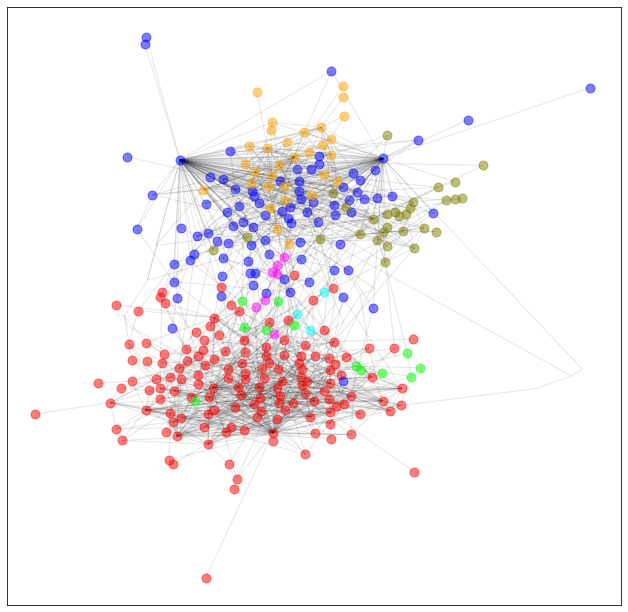

In [14]:
#list the nodes of each community
p0= list(dict(filter(lambda x: x[1] == 0, partition.items())).keys())
p1= list(dict(filter(lambda x: x[1] == 1, partition.items())).keys())
p2= list(dict(filter(lambda x: x[1] == 2, partition.items())).keys())
p3= list(dict(filter(lambda x: x[1] == 3, partition.items())).keys())
p4= list(dict(filter(lambda x: x[1] == 4, partition.items())).keys())
p5= list(dict(filter(lambda x: x[1] == 5, partition.items())).keys())
p6= list(dict(filter(lambda x: x[1] == 6, partition.items())).keys())

communities = [p0,p1,p2,p3,p4,p5,p6]
colours = ['red', 'lime', 'blue', 'orange', 'olive', 'magenta', 'Aqua']

#Plot the communities with different colours
plt.figure(figsize=(11,11)) 
for i,com in enumerate(communities, start=0):
    nx.draw_networkx_nodes(Gc, positions, nodelist=com,node_color=colours[i], node_size= 80, with_labels=False, alpha=0.5)

nx.draw_networkx_edges(Gc, positions, alpha=0.05)
nx.draw_networkx_edges(Gc,positions, alpha=0.05)
plt.show()

It can be observed that the largets communities are those of the party. But there is one community among the republican nodes and a few community that are more of a mix of the two parties. 

**Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.**

In [15]:
#Create confusion matrix

parties = [dem_nodes, rep_nodes]
B=2
C=len(set(partition.values()))
confusion_matrix=np.zeros( (B, C-1) )

for i,party in enumerate(parties, start=0):
    for j, com in enumerate(communities, start=0):
        confusion_matrix[i][j] = len(list(set(party).intersection(com)))
print('Confusion matrix:\n',confusion_matrix)
    

Confusion matrix:
 [[139.   8.   2.   1.   0.   4.   2.   0.   0.]
 [  3.   4.  84.  30.  29.   3.   1.   0.   0.]]


**Use the confusion matrix to explain how well the communities you've detected correspond to the parties. Consider the following questions**

- **Are there any republicans grouped with democrats (and vice versa)?**

There are two main communities that mainly consist of members within a single party. There are three very small communities that have fewer than 10 members, two are a mix between the parties and one consists only of two republicans. Then there is one slightly larger community (25 members) that is a mix between the two parties.

- **Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.**

The republican party has a small community within itself that only consists of republicans. It might be the tea party that we observe as this sub community. 

# Part 3 - Sentiment analysis

First of all we donwloaded the LabMT wordlist from the article [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article? id=10.1371/journal.pone.0026752)'s source files list. 

The file represents a set of 10,222 words, their average happiness evaluations according to users on Mechanical Turk, and other information. The words in set are ordered according to average happiness (descending), and the file contains eight columns:
    1. word
    2. rank
    3. average happiness (50 user evalutions)
    4. standard deviation of happiness
    5. Twitter rank
    6. Google Books rank
    7. New York Times rank
    8. Music Lyrics rank

The last four columns (Twitter rank, Google Books rank, New York Times rank, Music Lyrics rank) correspond to the ranking of a word by frequency of occurrence in the top 5000 words for the specified corpus. If the word is not in corpus the rank is a double dash ‘–’.


* Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
* Create two lists: one containing tweets by democratic members, and the other with the tweets of republican members. Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?
* Compute the average $m$ and standard deviation $\sigma$  of the Tweets sentiment (considering tweets by both republican and democrats). 
* Now only tweets with sentiment lower than $m-2\sigma$. We will refer to them as *negative* tweets.  Build a list containing *negative* tweets written by democrats, and one for republicans. Compute the TF-IDF on these two lists. Create a word-cloud for each of them. Are there differences between the positive content posted by republican and democrats?
* Repeat the point above, but considering _positive_ tweets (e.g. with sentiment larger than $m+2\sigma$). Comment on your results.


Create a csv representation of data downloaded from article

In [16]:
original_file = "Data_Set_S1.txt"
csv_file = "Happy_words.csv"

In [17]:
with open(original_file,"r") as inp:
    # Remove information lines 
    inp.readline()
    inp.readline()
    inp.readline()
    with open(csv_file,"w") as out:
        for data_line in inp:
            data_line = data_line.strip().split()
            out.write(",".join(data_line)+"\n")


In [18]:
# LOAD UP THE HAPPINES LIST:

happy_frame = pd.read_csv(csv_file)

print(happy_frame.columns)
happy_frame

Index(['word', 'happiness_rank', 'happiness_average',
       'happiness_standard_deviation', 'twitter_rank', 'google_rank',
       'nyt_rank', 'lyrics_rank'],
      dtype='object')


,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332
5,laugh,6,8.22,1.3746,1002,3998,4488,647
6,laughing,7,8.20,1.1066,1579,--,--,1122
7,excellent,8,8.18,1.1008,1496,1756,3155,--
8,laughs,9,8.18,1.1551,3554,--,--,2856
9,joy,10,8.16,1.0568,988,2336,2723,809


In [19]:
# To sppedup the sentiment function we will create a hashmap (dict) from words to their happiness score:
happines_score_dict = dict()
for val in happy_frame["word"]:
    happines_score_dict[val.lower()] = happy_frame[happy_frame["word"] == val]["happiness_average"].values[0]


In [20]:
def sentiment(token_list):
    """
    Returns the calculated sentiment value of list of tokens based on the happines list of words from 
    [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter]
    (http://journals.plos.org/plosone/article? id=10.1371/journal.pone.0026752)
    """
    if len(token_list) == 0:
        return 0
    res = 0
    for token in token_list:
        token = token.lower()
        if token in happines_score_dict:
            res += happines_score_dict[token]
    return res/len(token_list)
    # return res

Testing the function on short list of tokens

In [21]:
tokens = ["love", "life", "makaron"]
print(sentiment(tokens))

5.246666666666667


Get content of all tweets, tokenise them and save them into two list:

* list of demococratict tweets tokenized : demo_tweets_list
* list of republican tweets tokenized : repu_tweets_list


In [22]:
path = './tweets_2019/*'

demo_tweets_list = list()
repu_tweets_list = list()

for filename in glob.glob(path):
    m = filename[14:]
    tweet_name = df.loc[df['WikiPageName']==m]['tw_name'].item()
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()
    
    if party_name == "Democratic": 
        tweets_list = demo_tweets_list
    elif party_name == "Republican": 
        tweets_list = repu_tweets_list
    else:
        print("Unknown party: {0}".format(party_name))
        
    # English stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    # Spanish stopwords since some tweets are spanish
    stopwords_es = nltk.corpus.stopwords.words('spanish')
    
    tknzr = TweetTokenizer()
    with open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore') as inpfile:
        for tweet in inpfile:
            tokenized_tweet = tknzr.tokenize(tweet)
            # Remove stopword
            tokenized_tweet = [i for i in tokenized_tweet if i != "RT"]
            tokenized_tweet = [i for i in tokenized_tweet if i.lower() not in stopwords]
            tokenized_tweet = [i for i in tokenized_tweet if i.lower() not in stopwords_es]
            # Remove nonalphanumeric signs
            tokenized_tweet = [i.lower() for i in tokenized_tweet if i.isalnum()]
            tweets_list.append(tokenized_tweet)

#     with open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore') as inpfile:
#         for tweet in inpfile:
#             tweet = tweet.strip().split()
            
#             # Remove RT tag
#             tweet = [i for i in tweet if i != "RT"]
#             # Ensure lower case
#             tweet = [i.lower().replace(".","").replace("!","").replace("?","").replace(":","") for i in tweet]
    
#             #TODO should we remove links to tweets at the end of most of the tweets? 
            
#             # remove links
#             tweet = [i for i in tweet if i[:4] != "http"]
#             # remove RT tags and linking to other tweeter accounts
#             tweet = [i for i in tweet if "@" not in i]
            
#             tweets_list.append(tweet)
            
print("Democratny party number of tweets: {0}".format(str(len(demo_tweets_list))))
print("Republican party number of tweets: {0}".format(str(len(repu_tweets_list))))

all_tweets_num = len(repu_tweets_list) + len(demo_tweets_list)

Democratny party number of tweets: 63660
Republican party number of tweets: 56820


In [23]:
demo_sentiment_list = list()
repu_sentiment_list = list()

i = 0
j = 0
for tweet in demo_tweets_list:
    demo_sentiment_list.append(sentiment(tweet))
    if i%(all_tweets_num//20) == 0:
        print(j*100//20,"% done")
        j+=1
    i+=1
    
for tweet in repu_tweets_list:
    repu_sentiment_list.append(sentiment(tweet))
    if (i+2)%(all_tweets_num//20) == 0:
        print(j*100//20,"% done")
        j+=1
    i+=1


0 % done
5 % done
10 % done
15 % done
20 % done
25 % done
30 % done
35 % done
40 % done
45 % done
50 % done
55 % done
60 % done
65 % done
70 % done
75 % done
80 % done
85 % done
90 % done
95 % done
100 % done


Text(0.5, 1.0, 'Distribution of sentiment of democratic tweets')

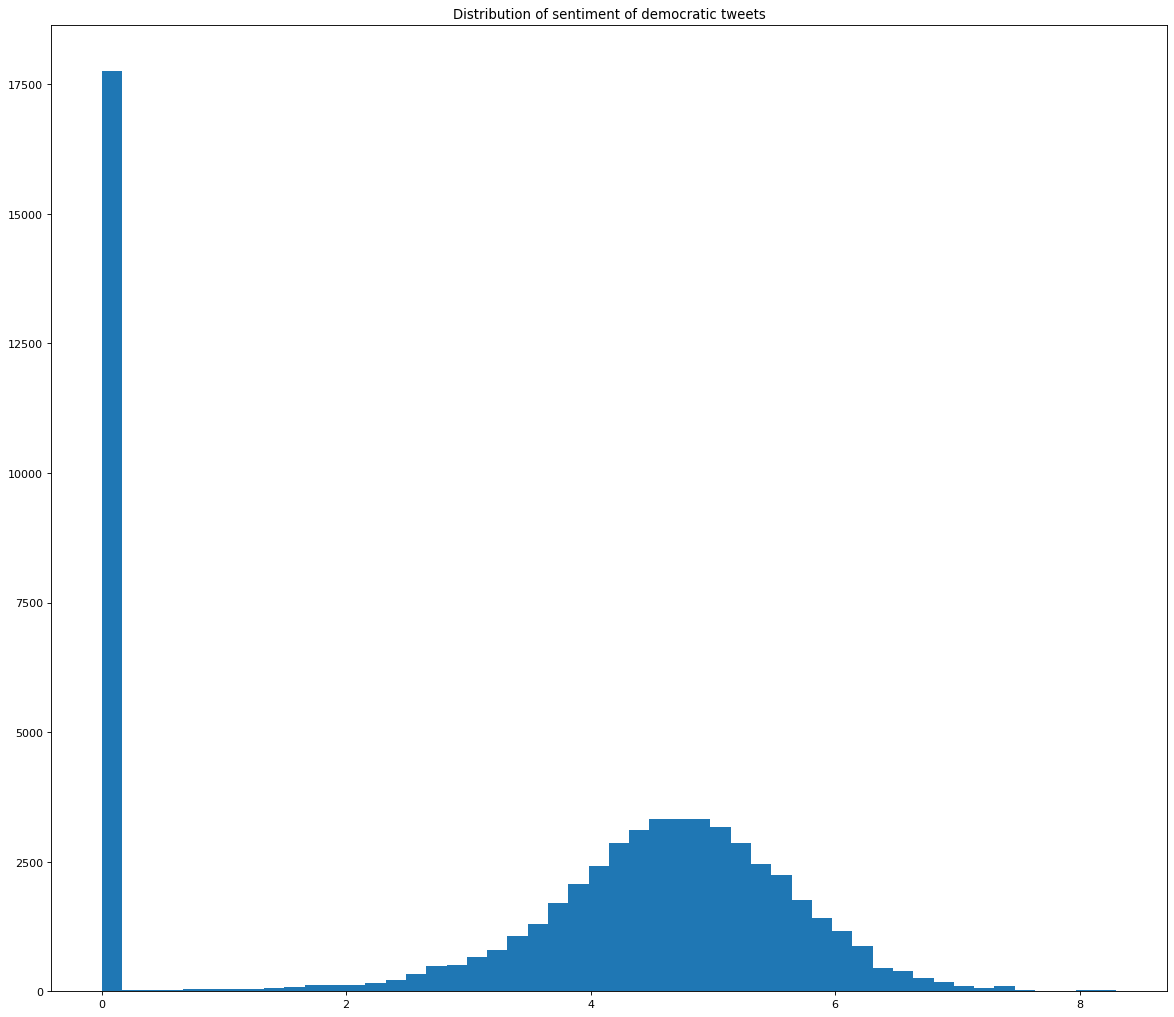

In [24]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(demo_sentiment_list, bins=50)
plt.title("Distribution of sentiment of democratic tweets")

In [25]:
demo_sentiment_nparray = np.array(demo_sentiment_list)
demo_sentiment_avrg = demo_sentiment_nparray.mean()
demo_sentiment_stdev = demo_sentiment_nparray.std()

print("Average sentiment of democratic tweets is: {0:.4f}".format(demo_sentiment_avrg))
print("Standard deviation of democratic tweets is: {0:.4f}".format(demo_sentiment_stdev))

# TODO exclude the ones where sentiment is 0

Average sentiment of democratic tweets is: 3.3620
Standard deviation of democratic tweets is: 2.2565


Text(0.5, 1.0, 'Distribution of sentiment of republican tweets')

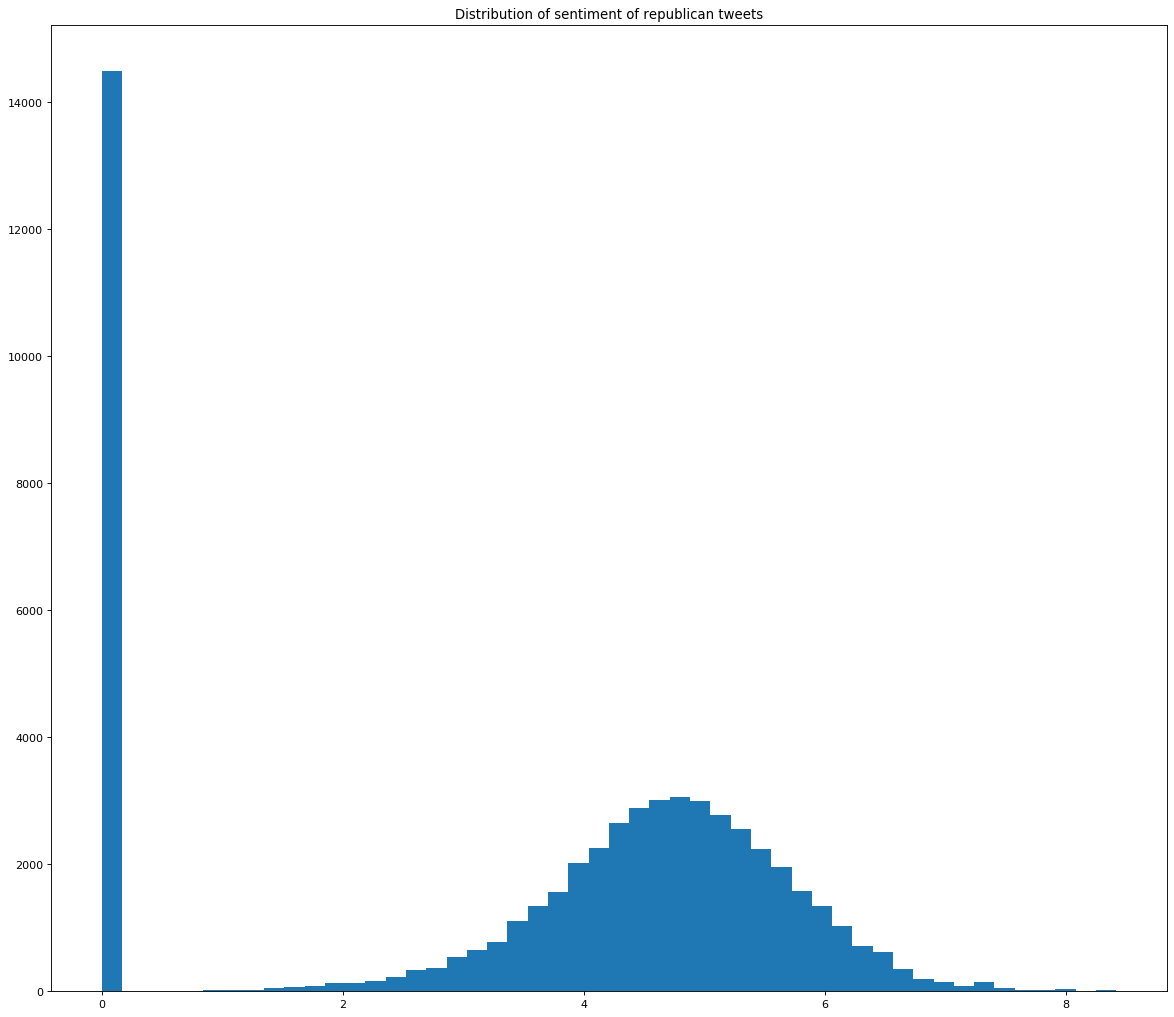

In [26]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(repu_sentiment_list, bins=50)
plt.title("Distribution of sentiment of republican tweets")

In [27]:
repu_sentiment_nparray = np.array(repu_sentiment_list)
repu_sentiment_avrg = repu_sentiment_nparray.mean()
repu_sentiment_stdev = repu_sentiment_nparray.std()

print("Average sentiment of republican tweets is: {0:.4f}".format(repu_sentiment_avrg))
print("Standard deviation of republican tweets is: {0:.4f}".format(repu_sentiment_stdev))

Average sentiment of republican tweets is: 3.5203
Standard deviation of republican tweets is: 2.2337


Are there significant differences between the two? Which party post more positive tweets?

There are no significant diffrences of sentiment of tweets between the two parties. But there are some minor differences.
We can se that Republicans tweet a little bit more positive on average.

Join the tweets sentiment and do the basic statistical analysis

In [28]:
all_tweets_sentiment = np.concatenate((demo_sentiment_nparray,repu_sentiment_nparray))

all_senti_avrg = all_tweets_sentiment.mean()
all_senti_stdev = all_tweets_sentiment.std()

print("Average sentiment of tweets is: {0:.4f}".format(all_senti_avrg))
print("Standard deviation of tweets is: {0:.4f}".format(all_senti_stdev))

Average sentiment of tweets is: 3.4366
Standard deviation of tweets is: 2.2471


Create a list of negative tweets for both parties

In [29]:
negativ_threshold = all_senti_avrg - 2*all_senti_stdev
posivie_threshold = all_senti_avrg + 2*all_senti_stdev

print("Tweets with value bellow {0} are considered negative!".format(negativ_threshold))
print("Tweets with value abbove {0} are considered postvite!".format(posivie_threshold))

Tweets with value bellow -1.0576384845710676 are considered negative!
Tweets with value abbove 7.9309379530664765 are considered postvite!


This makes almost zero sense since there are no tweets that are positive or negative. We will remove tweets with sentiment value of 0

In [30]:
# negative_demo_tweets = list()
# positive_demo_tweets = list()
# negative_repu_tweets = list()
# positive_repu_tweets = list()

# i = 0
# j = 0
# for tweet in demo_tweets_list:
#     tweet_sentiment = sentiment(tweet)
#     if tweet_sentiment >= posivie_threshold:
#         positive_demo_tweets.append(tweet)
#     elif tweet_sentiment <= negativ_threshold:
#         negative_demo_tweets.append(tweet)
#     else:
#         pass
#     if i%(all_tweets_num//20) == 0:
#         print(j*100//20,"% done")
#         j+=1
#     i+=1
    
# for tweet in repu_tweets_list:
#     tweet_sentiment = sentiment(tweet)
#     if tweet_sentiment >= posivie_threshold:
#         positive_repu_tweets.append(tweet)
#     elif tweet_sentiment <= negativ_threshold:
#         negative_repu_tweets.append(tweet)
#     else:
#         pass
#     if i%(all_tweets_num//20) == 0:
#         print(j*100//20,"% done")
#         j+=1
#     i+=1

### Part 3 with removed tweets with sentiment of 0


In [31]:
demo_sentiment_list = list()
repu_sentiment_list = list()

i = 0
j = 0
for tweet in demo_tweets_list:
    stotwwet = sentiment(tweet)
    if stotwwet != 0:
        demo_sentiment_list.append(stotwwet)
    if i%(all_tweets_num//20) == 0:
        print(j*100//20,"% done")
        j+=1
    i+=1
    
for tweet in repu_tweets_list:
    stotwwet = sentiment(tweet)
    if stotwwet != 0:
        repu_sentiment_list.append(stotwwet)
    if (i+2)%(all_tweets_num//20) == 0:
        print(j*100//20,"% done")
        j+=1
    i+=1


0 % done
5 % done
10 % done
15 % done
20 % done
25 % done
30 % done
35 % done
40 % done
45 % done
50 % done
55 % done
60 % done
65 % done
70 % done
75 % done
80 % done
85 % done
90 % done
95 % done
100 % done


Text(0.5, 1.0, 'Distribution of sentiment of democratic tweets')

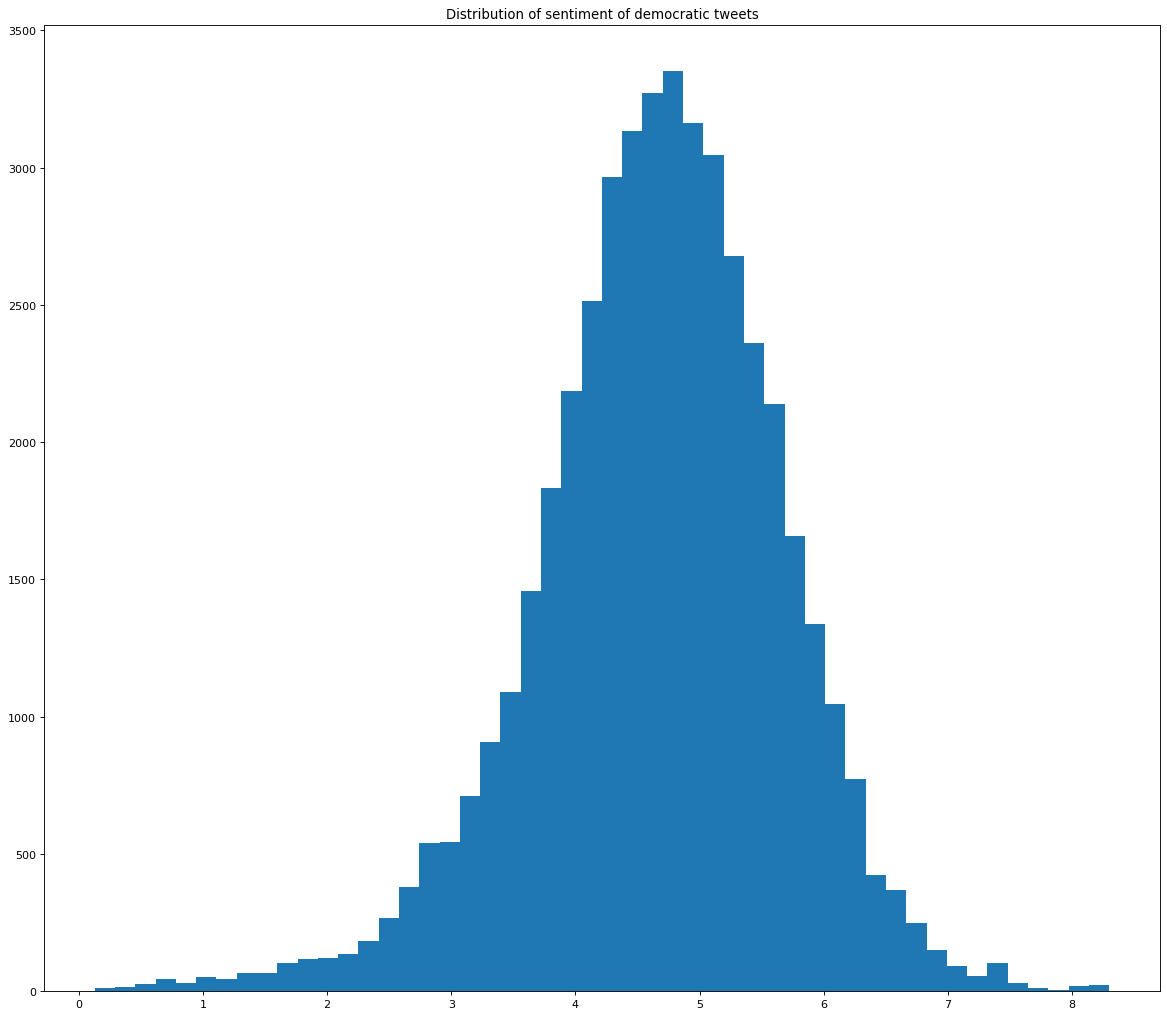

In [32]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(demo_sentiment_list, bins=50)
plt.title("Distribution of sentiment of democratic tweets")

In [33]:
demo_sentiment_nparray = np.array(demo_sentiment_list)
demo_sentiment_avrg = demo_sentiment_nparray.mean()
demo_sentiment_stdev = demo_sentiment_nparray.std()

print("Average sentiment of democratic tweets is: {0:.4f}".format(demo_sentiment_avrg))
print("Standard deviation of democratic tweets is: {0:.4f}".format(demo_sentiment_stdev))

# TODO exclude the ones where sentiment is 0

Average sentiment of democratic tweets is: 4.6628
Standard deviation of democratic tweets is: 0.9984


Text(0.5, 1.0, 'Distribution of sentiment of republican tweets')

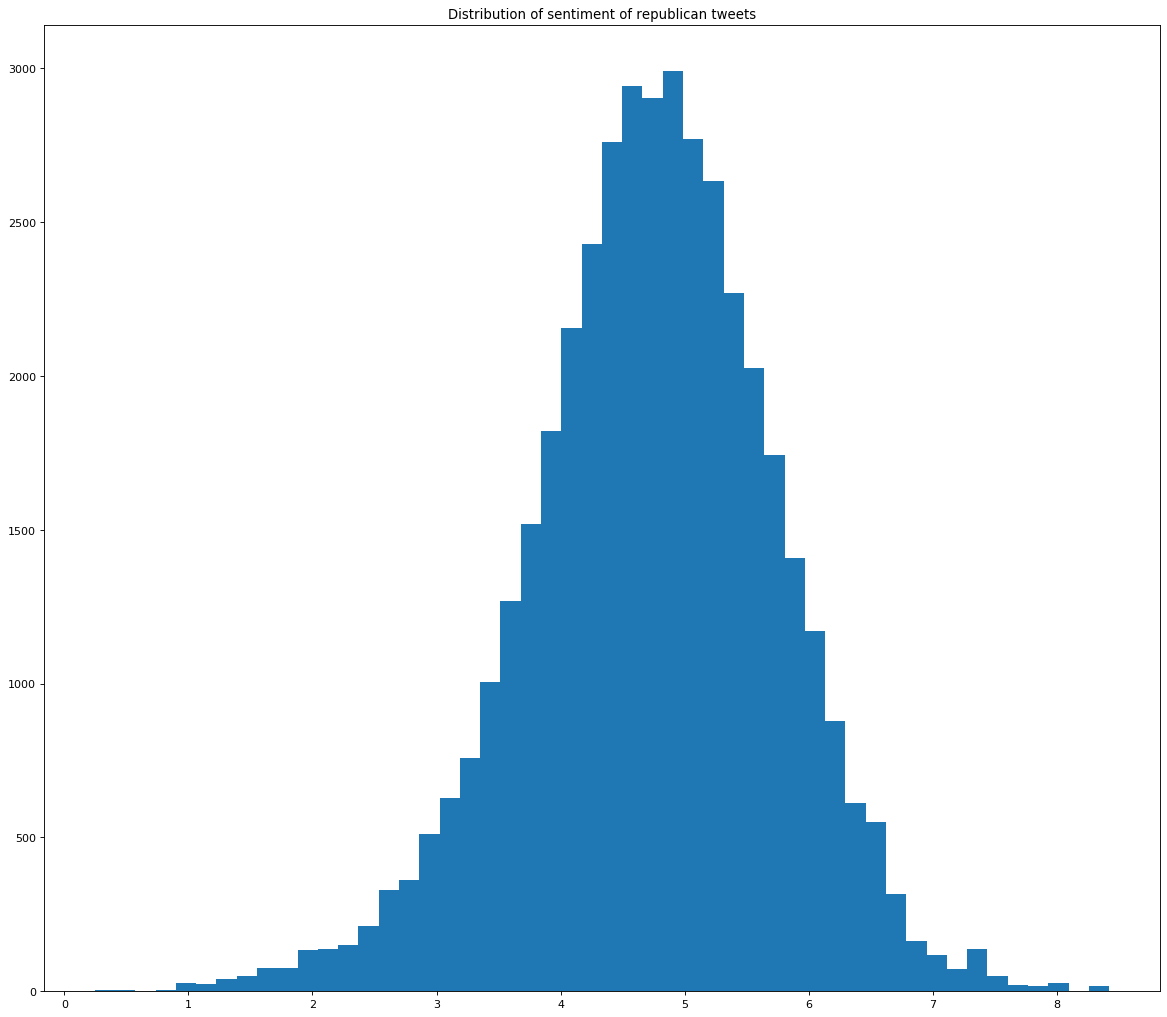

In [34]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(repu_sentiment_list, bins=50)
plt.title("Distribution of sentiment of republican tweets")

In [35]:
repu_sentiment_nparray = np.array(repu_sentiment_list)
repu_sentiment_avrg = repu_sentiment_nparray.mean()
repu_sentiment_stdev = repu_sentiment_nparray.std()

print("Average sentiment of republican tweets is: {0:.4f}".format(repu_sentiment_avrg))
print("Standard deviation of republican tweets is: {0:.4f}".format(repu_sentiment_stdev))

Average sentiment of republican tweets is: 4.7261
Standard deviation of republican tweets is: 0.9997


Again if we remove 0 sentiment value tweets we can se republicans tweet happier tweets in general. But with even less of a difference then before.

In [36]:
all_tweets_sentiment = np.concatenate((demo_sentiment_nparray,repu_sentiment_nparray))

all_senti_avrg = all_tweets_sentiment.mean()
all_senti_stdev = all_tweets_sentiment.std()

print("Average sentiment of tweets is: {0:.4f}".format(all_senti_avrg))
print("Standard deviation of tweets is: {0:.4f}".format(all_senti_stdev))

Average sentiment of tweets is: 4.6931
Standard deviation of tweets is: 0.9995


In [37]:
negativ_threshold = all_senti_avrg - 2*all_senti_stdev
posivie_threshold = all_senti_avrg + 2*all_senti_stdev

print("Tweets with value bellow {0} are considered negative!".format(negativ_threshold))
print("Tweets with value abbove {0} are considered postvite!".format(posivie_threshold))

Tweets with value bellow 2.6941372856050254 are considered negative!
Tweets with value abbove 6.692142184429512 are considered postvite!


We will create 4 lists of tweets:
* Negative democratic tweets
* Positive democratic tweets
* Negative republican tweets
* Positive republican tweets


In [38]:
negative_demo_tweets = list()
positive_demo_tweets = list()
negative_repu_tweets = list()
positive_repu_tweets = list()

i = 0
j = 0
for tweet in demo_tweets_list:
    tweet_sentiment = sentiment(tweet)
    if tweet_sentiment >= posivie_threshold:
        positive_demo_tweets.append(tweet)
    elif tweet_sentiment <= negativ_threshold:
        negative_demo_tweets.append(tweet)
    else:
        pass
    if i%(all_tweets_num//20) == 0:
        print(j*100//20,"% done")
        j+=1
    i+=1
    
for tweet in repu_tweets_list:
    tweet_sentiment = sentiment(tweet)
    if tweet_sentiment >= posivie_threshold:
        positive_repu_tweets.append(tweet)
    elif tweet_sentiment <= negativ_threshold:
        negative_repu_tweets.append(tweet)
    else:
        pass
    if (i+2)%(all_tweets_num//20) == 0:
        print(j*100//20,"% done")
        j+=1
    i+=1

0 % done
5 % done
10 % done
15 % done
20 % done
25 % done
30 % done
35 % done
40 % done
45 % done
50 % done
55 % done
60 % done
65 % done
70 % done
75 % done
80 % done
85 % done
90 % done
95 % done
100 % done


In [39]:
def tf_calculator_2(mat):
    tf = dict()
    for tweet in mat:
        for token in tweet:
            if token in tf:
                tf[token] += 1
            else:
                tf[token] = 1
    return tf

In [40]:
tf_negative_demo = tf_calculator_2(negative_demo_tweets)
tf_negative_repu = tf_calculator_2(negative_repu_tweets)
sorted_negative_demo_tfidf = sorted(tf_negative_demo.items(), key=operator.itemgetter(1), reverse=True)
sorted_negative_repu_tfidf = sorted(tf_negative_repu.items(), key=operator.itemgetter(1), reverse=True)

[('trump', 104), ('2', 61), ('impeachment', 58), ('1', 56), ('3', 38), ('congressman', 36), ('4', 33), ('5', 33), ('ukraine', 32), ('si', 31), ('bills', 29), ('threatening', 28), ('inquiry', 27), ('whistleblower', 27), ('hoy', 26), ('must', 25), ('información', 25), ('drilling', 25), ('inmigración', 24), ('president', 24)]


(-0.5, 299.5, 299.5, -0.5)

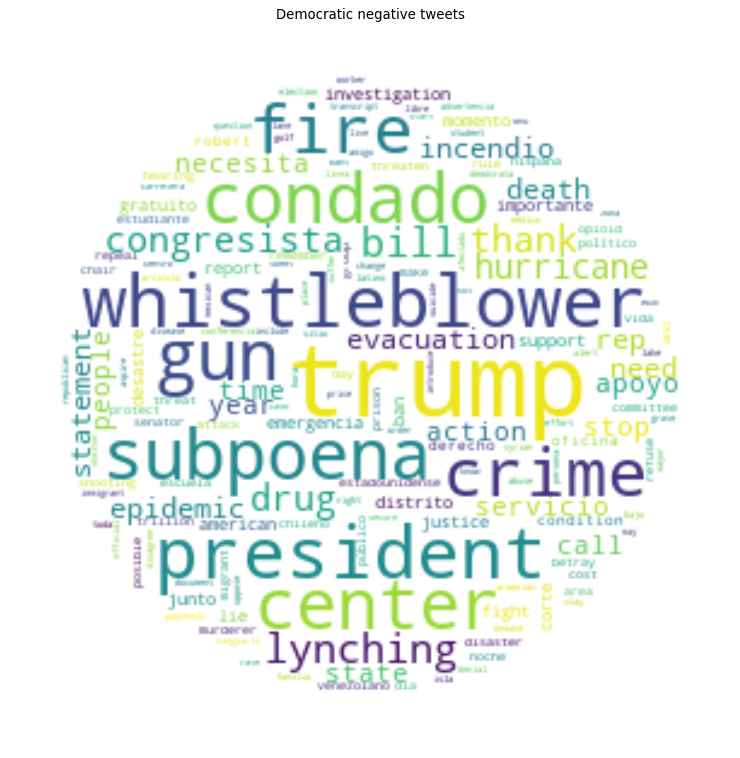

In [64]:
demo_cloud_string = " ".join([i[0] for i in sorted_negative_demo_tfidf])

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(background_color="white", mask = mask).generate(demo_cloud_string)

plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Democratic negative tweets")
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

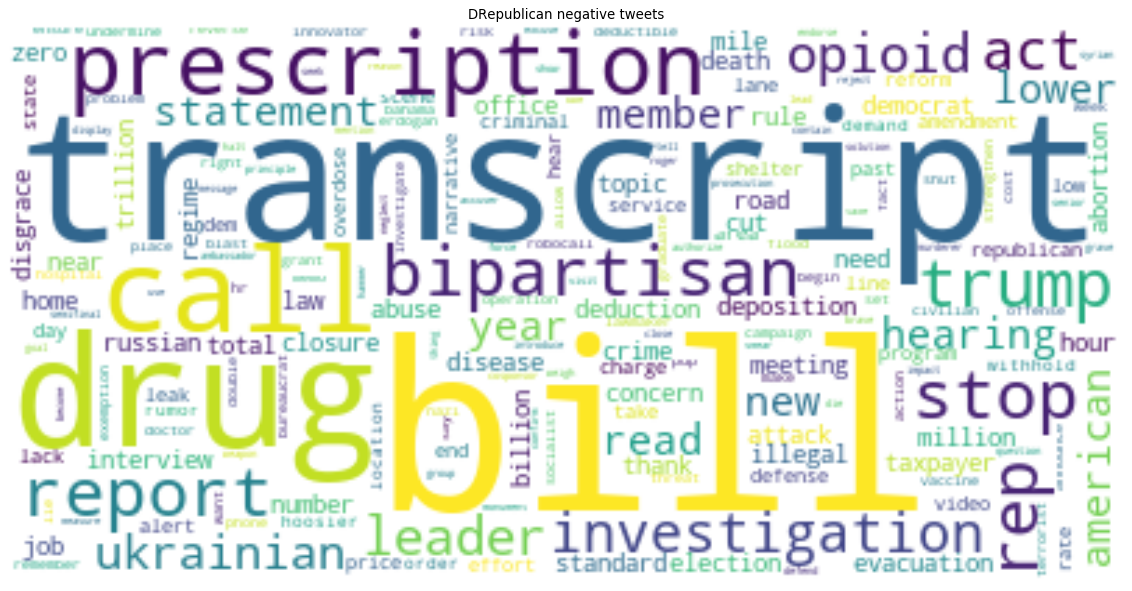

In [65]:
repu_cloud_string = " ".join([i[0] for i in sorted_negative_repu_tfidf])

wordcloud = WordCloud(background_color="white").generate(repu_cloud_string)

plt.figure(figsize=(18, 16), dpi= 80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("DRepublican negative tweets")
plt.axis("off")

*Are there differences between the negative content posted by republican and democrats?*

TODO


Positive Tweets

In [51]:
tf_positive_demo = tf_calculator_2(positive_demo_tweets)
tf_positive_repu = tf_calculator_2(positive_repu_tweets)
sorted_positive_demo_tfidf = sorted(tf_positive_demo.items(), key=operator.itemgetter(1), reverse=True)
sorted_positive_repu_tfidf = sorted(tf_positive_repu.items(), key=operator.itemgetter(1), reverse=True)

(-0.5, 399.5, 199.5, -0.5)

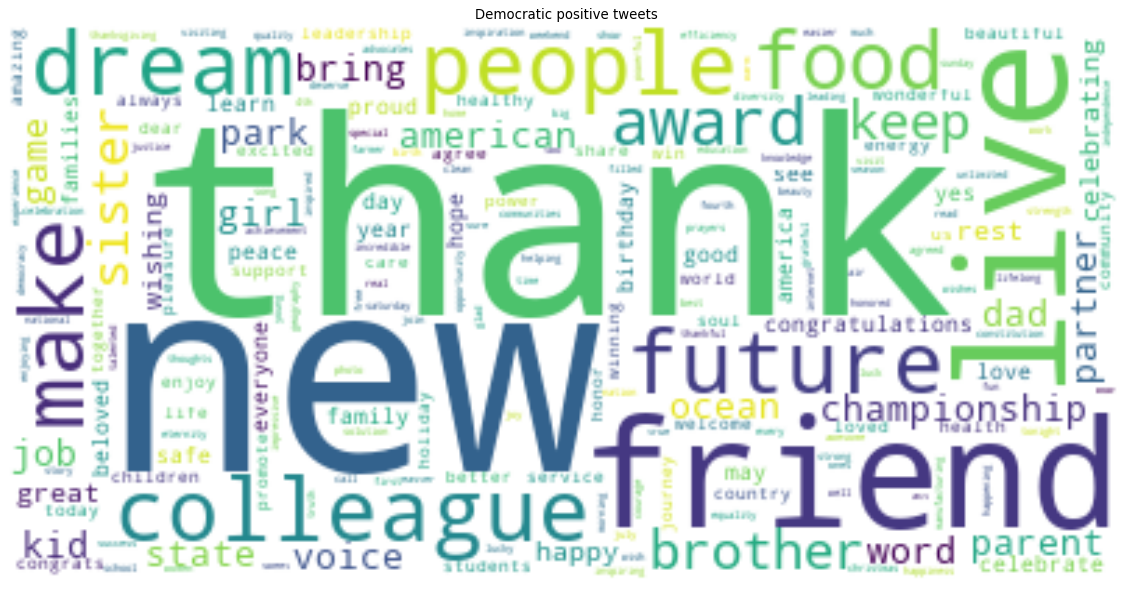

In [57]:
demo_cloud_string = " ".join([i[0] for i in sorted_positive_demo_tfidf])

wordcloud = WordCloud(background_color="white").generate(demo_cloud_string)

plt.figure(figsize=(18, 16), dpi= 80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Democratic positive tweets")
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

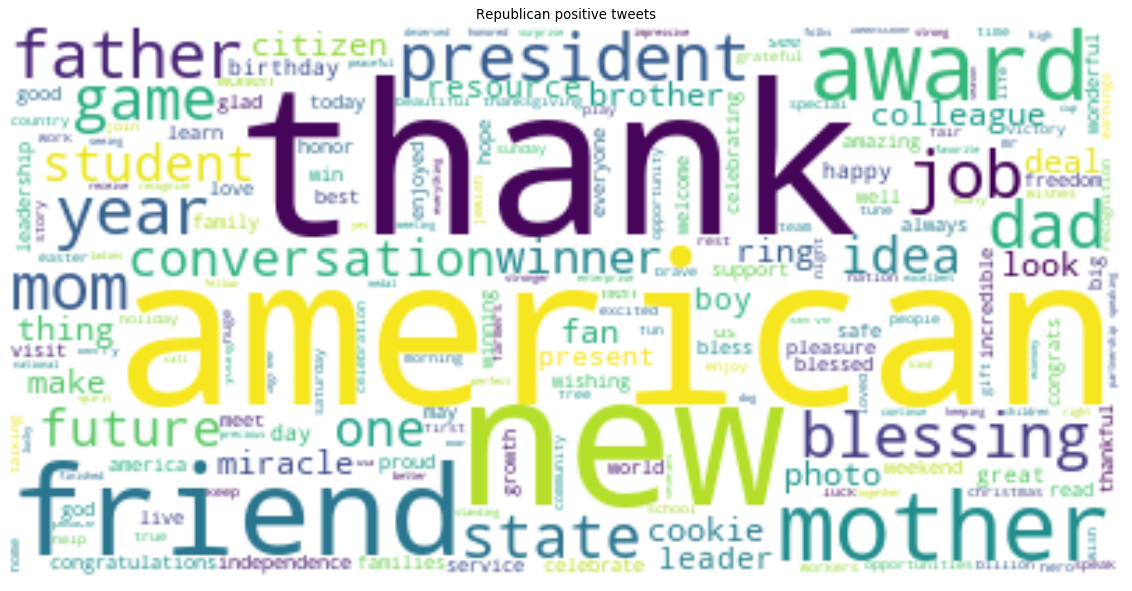

In [58]:
repu_cloud_string = " ".join([i[0] for i in sorted_positive_repu_tfidf])

wordcloud = WordCloud(background_color="white").generate(repu_cloud_string)

plt.figure(figsize=(18, 16), dpi= 80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Republican positive tweets")
plt.axis("off")

*Are there differences between the negative content posted by republican and democrats?*

TODO
